## Black Box Variational Inference with Edward

In this tutorial we will demonstrate how to apply black box variational inference (BBVI) to learn the parameters of a given model. Black box variational inference is a Bayesian inference method that has been introduced by [Paisley et al.](http://www.columbia.edu/~jwp2128/Papers/PaisleyBleiJordan2012b.pdf) and later by [Ranganath et al.](http://www.cs.columbia.edu/~blei/papers/RanganathGerrishBlei2014.pdf). Please read those references for further detail. 

Let's say you have some data and you have some model in mind that you want to fit to it. The model has some parameters/latent variables that you need to learn. You can use the Bayesian paradigm to do so. Doing Bayesian inference boils down to computing the posterior distribution of the latent variables conditional on the observed data. 

Let $x$ denote the observed data and $z$ the vector of latent variables - the unknowns of your model you want to learn. Adopting the Bayesian framework, you put a prior on $z$ and aim to learn the posterior distribution
\begin{equation*}
p(z|x) = \frac{p(x, z)}{p(x)} = \frac{p(x|z)p(z)}{p(x)} 
\end{equation*}
$p(x|z)$ is called the likelihood.
$p(z)$ is the prior and
$p(x)$ is the marginal likelihood or the model evidence.

In most machine learning applications the posterior is intractable because $p(x)$ is unknown and cannot be computed in closed-form. One solution is to approximate it. 

Existing approximation schemes include Monte Carlo methods, Laplace approximation, variational inference and expectation propagation. Most of these inference algorithms are implemented in Edward. This tutorial focuses on BBVI which is a variant of variational inference.

Variational inference approximates a posterior distribution by following this procedure:

1 - since we do not know which family of distribution our posterior belongs to, we choose one that is plausible and tractable and we call it $q$. This distribution $q$ has some parameters as all distributions do. These are called the variational parameters. For example for a Gaussian these are the mean and the variance. For a beta distribution these are the shape and scale parameters etc. Call these variational parameters $\lambda$

2 - choose the variational parameters $\lambda$ such that $q$ is close to our posterior. What does it mean for $q$ to be close to the posterior $p$? It means the Kullback-Leibler divergence $KL(q || p)$ between $q$ and $p$ is minimized.

Variational inference thus translates the approximate posterior inference problem into an optimization problem by positing a family of distributions governed by a set of parameters $\lambda$ and seeking the setting of these parameters that will minimize the KL divergence. 
The optimization problem is:
\begin{equation*}
q^*(z|\lambda^*) =  \underset{q(z|\lambda)}{argmin}
\operatorname{KL}(q(z|\lambda) || p(z | x))
\end{equation*}
where
\begin{equation*}
\operatorname{KL}(q(z|\lambda) || p(z | x)) = \mathbb{E}_q\log\Big(\frac{q(z | \lambda)}{p(z | x)}\Big)
\end{equation*}

You might notice that this KL objective function is still intractable but fortunately:
\begin{equation*}
\log(p(x)) = KL(q(z|\lambda) || p(z | x)) + \mathbb{E}_q\log\Big(\frac{p(x, z)}{q(z | \lambda)}\Big)
\end{equation*}
In the Bayesian setting $\log(p(x))$ is fixed and so minimizing the
KL divergence is equivalent to maximizing the quantity known as the Evidence Lower Bound (ELBO)
\begin{equation*}
ELBO(\lambda) = \mathbb{E}_q\log\Big(\frac{p(x, z)}{q(z | \lambda)}\Big)
\end{equation*}

By positivity of the KL divergence, the ELBO is a tractable lower bound of the marginal likelihood of the data and is optimized over the variational parameters. Once optimization is done $q^*(z|\lambda^*)$ is used as a surrogate for the posterior $p(z | x)$.

To get some intuition about the ELBO notice that it can be rewritten as:
\begin{align*}
ELBO(\lambda) 
&= \mathbb{E}_q[\log p(x|z)]  + \mathbb{E}_q[\log p(z)] - \mathbb{E}_q[\log q(z)] \\ 
&= \mathbb{E}_q\log p(x|z)  - KL(q(z) || p(z))
\end{align*}

this tells us that the optimal variational distribution $q$ that maximizes the ELBO will place mass such that the data is very likely while agreeing with the prior distribution. The second term acts as a regularizer. This is the usual trade-off between data and prior information in the Bayesian paradigm.

BBVI is an algorithm for maximizing the ELBO. It does so by following not the gradient of the ELBO as you would do in a trivial gradient ascent algorithm but by following Monte Carlo estimates of the gradient of the ELBO. 

There are different types of gradients each of which can be used in BBVI. The score function gradient is trivially:
$$\mathbb{E}_q\Big[\log\Big(\frac{p(x,z)}{q(z|\lambda)}\Big)\bigtriangledown_{\lambda}\log q(z|\lambda) \Big]$$

This score function gradient can be refactored into a reparameterization gradient if the variational distribution $q$ can be reparameterized. For example when $q$ is $N(z| \mu, \Sigma)$ then you can rewrite any sample $z$ from $q$ as $z = \mu + \Sigma^{1/2}\epsilon$ where $\epsilon \sim N(0, I)$. 

The reparametrization gradient when $z = g(\lambda, \epsilon)$ and $\epsilon \sim p(\epsilon)$ is:
$$\mathbb{E}_{p(\epsilon)}\Big[\bigtriangledown_{\lambda}\log\Big(\frac{p(x, g(\lambda, \epsilon))}{q(g(\lambda, \epsilon) | \lambda)} \Big)\Big]$$
This comes from the fact that:
\begin{align*}
  ELBO &= \mathbb{E}_q[\log p(x, z)] - \mathbb{E}_q[\log q(z)] \\
  &= \mathbb{E}_{p(\epsilon)}[\log p(x, g(\lambda, \epsilon))] - \mathbb{E}_{p(\epsilon)}[\log q(g(\lambda, \epsilon))] \\
  &= \mathbb{E}_{p(\epsilon)}\Big[\log\Big(\frac{p(x, g(\lambda, \epsilon))}{q(g(\lambda, \epsilon) | \lambda)} \Big)\Big]
\end{align*}

Then passing the differentiation right into this expectation yields the result.

The score function gradients and reparameterization gradients are implemented in Edward along with other gradients. The default is the reparameterization gradient since it tends to have lower variance than the score gradient and since most of the distributions used in practice are reparameterizable. 

We illustrate BBVI using a simple logistic regression example. Our setting is as follows:

We are given a dataset $\{x_i, y_i\}$ for $i=1, ... , N$ where each $x_i$ lives for example in a two-dimensional space and each $y_i$ is in $\{0, 1\}$. You can think of each $(x_i, y_i)$ pair as an individual whose features are $x_i$ and whose label is $y_i$. 

Let's generate and visualize some toy data that we can illustrate our example with. Unfortunately Edward does not have yet data generators. This will be in subsequent versions. However we can generate data very easily as follows:

In [1]:
import numpy as np
np.random.seed(0)

N = 100
x1 = np.random.normal(loc=[-2, 5], scale=[2, 3], size=(N, 2)) #class 1
x2 = np.random.normal(loc=[2, -3], scale=[1, 2], size=(N, 2)) #class 2
x = np.vstack((x1, x2))
y1 = np.zeros(N)
y2 = np.ones(N)
y = np.hstack((y1, y2))

where we set the seed to 10 for reproducibility. 

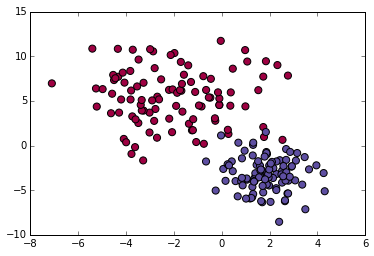

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.Spectral)
plt.show()

The data we generated has two classes: red and blue. You can think of the red dots as sick patients and the blue dots as healthy patients. The horizontal and vertical coordinates can be thought of as some risk factors for some disease. The data is linearly separable. We can draw a straight line to separate the sick from the healthy patients. Logistic regression seems to be a good classifier for this data. 

Our goal is to train a classifier that will predict whether an individual is sick or healthy given their risk factors.

There are three things we need to provide to apply BBVI. We need to provide the likelihood, the prior and the variational distribution. The likelihood and the prior define the model and this is done in Edward by specifying a class with a method called log_prob that defines the log joint likelihood:

In [4]:
import tensorflow as tf
import edward as ed

from edward.stats import bernoulli

class LogisticRegression:
    """
    Hierarchical logistic regression for outputs y on inputs x.
    p(y | z ; x) = Bernoulli(y | \sigmoid(x*z))
    p(z) = Normal(z | 0, prior_variance)
    
    where z are weights and prior_variance is known.
    """
    def __init__(self, weight_dim, N, inv_link=tf.sigmoid, prior_variance=0.01):
        """
        Initializes the parameters of the model
        weight_dim: 
            the dimension of the feature vector for each individual
            it is 2 in our example
        """
        self.weight_dim = weight_dim
        self.inv_link = inv_link
        self.N = N
        self.prior_variance = prior_variance
        self.num_vars = (self.weight_dim[0] + 1)* (self.weight_dim[1])
    
    def mapping(self, x, z):
        """
        Inverse link function on linear transformation,
        sigmoid(W*x + b)
        """
        m, n = self.weight_dim[0], self.weight_dim[1]
        W = tf.reshape(z[:m*n], [m, n])
        b = tf.reshape(z[m*n:], [1, n])
        h = self.inv_link((tf.matmul(x, W) + b))
        h = tf.squeeze(h) 
        return h

    def log_prob(self, xs, zs):
        """Returns a vector [log p(xs, zs[1,:]), ..., log p(xs, zs[S,:])].
           The labels must be in the first column"""
        y = xs[:, 0]
        x = xs[:, 1:]
        log_lik = []
        for z in tf.unpack(zs):
            p = self.mapping(x, z)
            log_lik += [bernoulli.logpmf(y, p)]

        log_lik = tf.pack(log_lik)
        #log_lik = tf.reduce_sum(log_lik, 1)
        log_prior = -0.5*tf.log(2*np.pi) - 0.5 * tf.log(self.prior_variance) -\
                    (0.5 / self.prior_variance) * tf.reduce_sum(zs*zs, 1)

        return log_lik + log_prior

ed.set_seed(10)
model = LogisticRegression(weight_dim=[2,1], N=200)

Once the model is defined, we need to specify the variational distribution. In Edward this is done by instantiating a Variational object and then adding a distribution layer to it:

In [5]:
from edward.models import Variational, Normal

variational = Variational()
variational.add(Normal(model.num_vars))

One last thing to take care of is that we need to get the data into a Data object for Edward to use. We do so as follow:

In [6]:
raw_data = np.hstack((y.reshape(2 * N, 1), x))
data = ed.Data(tf.constant(raw_data, dtype=tf.float32))

We have all the ingredients necessary to run the BBVI algorithm: we have the data, the model and the variational distribution. To run BBVI we instantiate an MFVI object:

In [7]:
inference = ed.MFVI(model, variational, data)

From here on you have two options. You can either just do 
inference.run() to get the final values of the optimal latent variables or you can launch a new session and get a handle on the detailed results as follows:

In [8]:
inference.initialize()
sess = ed.get_session()
elbo = []
for t in range(200):
    loss = inference.update()
    elbo.append(loss)

We then plot the ELBO to assess convergence:

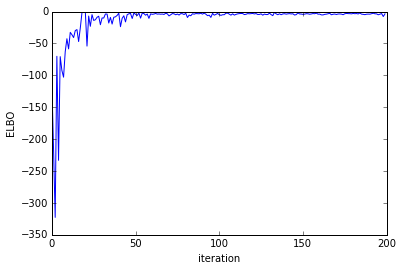

In [9]:
plt.plot(elbo)
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.show()

This is looking good. The ELBO is increasing as it is supposed to. It is not monotonically increasing, there are some dips here and there but that is expected since it is stochastic. We can print the values of the mean and the variance of the approximate posterior:

In [10]:
print(variational)

mean: 
[ 0.03274653  0.07455338  0.02321811]
std dev: 
[ 0.11167798  0.10770528  0.10951065]


Let's store these values in two variables mean and std:

In [11]:
mean, std = sess.run([variational.layers[0].loc, variational.layers[0].scale])

This is three dimentional instead of two-dimentional because we included the intercept.

Now let's make some predictions. We have two choices. We can simply sample w from the variational distribution and use that value to compute the score. The second option is to compute the posterior predictive distribution. In the case of logistic regression, the posterior predictive distribution for the class 1 (label is 1) is a convolution between a sigmoid and a Gaussian (the variational distribution was chosen to be Gaussian). You can then use the trick of approximating the sigmoid with the probit link to get an analytic posterior predictive distribution.  

We choose the first option for simplicity. The prediction function for a sampled weight w is:

In [12]:
def pred_function(w, x):   
    score = np.dot(x, w[:2]) + w[2]
    return score >= 0

Now let's see what the decision boundary looks like for two different weight samples:

[[-0.30000882  0.0684658   0.15661838]
 [ 0.08421763 -0.17264137  0.09575512]]


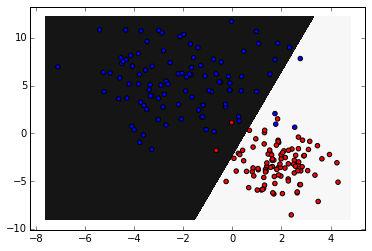

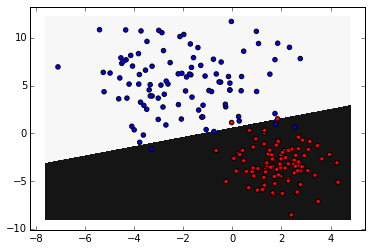

In [31]:
def plot_boundary(pred_function, x, y):
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5 # horizontal axis
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5 # vertical axis
    h = 0.01 # the step size
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Greys)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.bwr)
    plt.show()
    
w_samples = np.random.multivariate_normal(mean, np.diag(std**2), size=2)
print(w_samples)
for w in w_samples:
    plot_boundary(lambda x: pred_function(w, x), x, y)

There you have it! Now you have a reasonable understanding of BBVI and you can apply it to a model like logistic regression using Edward. Try other models to solidify your understanding. 